<a href="https://colab.research.google.com/github/connor-verheyen/COVID19_IndoorRH/blob/main/supplementary_analysis/Supplementary_Section_09__Repeat_Analysis_With_Dec_Jan_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import scipy as sp 
import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import matplotlib.dates as md
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set seaborn plotting style 
sns.set(context='talk', font_scale=0.9, style='ticks', palette='Blues_d')

# # For a specific version of seaborn package 
# !pip install seaborn==0.10.1

In [ ]:
# Function to create lags of a given variable 

def make_lags(dataframe,merging_var,variable,num_lags):
  df = dataframe[['Country',merging_var,variable]].copy() # Make a copy of the country (for grouping) and the variable to be lagged  

  for i in range(1,num_lags+1):
    df[variable+'_lag{}'.format(i)] = df.groupby('Country')[variable].shift(i) # Create all of the lags of the given input variable 

  return df

In [ ]:
# Function to create a dataframe with lagged versions of the variable and the actual outbreak metrics 

def lagged_var_df(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  outcomes = df[COVIDstats]

  lagged_variables = make_lags(dataframe,merging_var,variable,num_lags)

  merged = lagged_variables.merge(right=outcomes,how='left',on=['Country',merging_var])

  return merged

In [ ]:
# Function to discretize continuous variables 
def quantizer(dataframe, first_day, last_day, qlevels, countries, retbins):

  # Dataframe to use for plotting -> Set lower and upper bound for days from 5th death, only use the selected list of countries (could be all, n_hem, s_hem, trop, or for a given month)
  df = dataframe[(dataframe['Days From 5th Death'].ge(first_day)) & (dataframe['Days From 5th Death'].le(last_day)) & (dataframe['Country'].isin(countries))].copy()

  if retbins == True: # return the bin ranges and label each category with the bin range 
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
  
  else: # don't retun the bin ranges and label each category with an integer
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,duplicates='drop',labels=False).astype('category')

  return df

In [ ]:
# Function to compute odds ratios 
import statsmodels.api as sm

def oddsratio(dataset,outcome,treatment):
  
  data = dataset[[outcome,treatment]].copy() # Copy dataset 

  contig_table = pd.crosstab(data[outcome],data[treatment]).iloc[::-1,] # Make a 2x2 contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 
  #print(contig_table)

  table = sm.stats.Table2x2(np.asarray(contig_table)) # Use statsmodels to turn the contingency table into a special 2x2 table for further statsmodels calculations 
  #print(table)

  #table=sm.stats.Table2x2.from_data(data) # Make a contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 

  odds_badoutcome_notreatment = contig_table.iloc[0,0]/contig_table.iloc[1,0] # Odds of having a worse outcome (e.g. more deaths) WITHOUT treatment (e.g. RH<40% or RH>60%) 
  odds_badoutcome_withtreatment = contig_table.iloc[0,1]/contig_table.iloc[1,1] # Odds of having a worse outcome (e.g. more deaths) WITH treatment (e.g. RH 40%-60%) 

  odds_ratio = table.oddsratio # Odds ratio (ratio of odds_badoutcome_notreatment to odds_badoutcome_withtreatment) -> how much more likely are you to have a bad outcome if you don't receive the treatment 
  LCB = table.oddsratio_confint()[0] # Lower 95% confidence boundary
  UCB = table.oddsratio_confint()[1] # Upper 95% confidence boundary 
  pval = table.oddsratio_pvalue() # p-value for a hypothesis test about the odds ratio

  return odds_badoutcome_notreatment, odds_badoutcome_withtreatment, odds_ratio, LCB, UCB, pval 

# To run function... 
# oddsratio(dataset=treat_total,outcome='new_cases_Qlevels',treatment='quantized_IndRH')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Analysis on December dataset

In [ ]:
# 
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/7DaySmooth_ALLVars_Dataset_2020_12_03_GE50_Deaths.csv'

# Import Files #df = pd.read_excel('PADDED_Dataset_2020_08_10_GE50_Deaths.xlsx')
df7all = pd.read_csv(filename)

# Drop unnecessary index columns #df.drop(columns='Unnamed: 0',axis=1,inplace=True)
df7all.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Tropic of Cancer is located at 23.5 degrees north of the equator and runs through Mexico, the Bahamas, Egypt, Saudi Arabia, India, and southern China # The Tropic of Capricorn lies at 23.5 degrees south of the equator and runs through Australia, Chile, southern Brazil, and northern South Africa
upper_lat_bound = 23.5; lower_lat_bound = -23.5 
n_hem = df7all[df7all['Lat']>upper_lat_bound]; s_hem = df7all[df7all['Lat']<lower_lat_bound]; trop  = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>lower_lat_bound)]

print('Total Country Count:',df7all['Country'].unique().shape[0]); print('Northern Hemisphere Country Count:',n_hem['Country'].unique().shape[0]); print('Southern Hemisphere Country Count:',s_hem['Country'].unique().shape[0]); print('Tropics Country Count:',trop['Country'].unique().shape[0])

Total Country Count: 148
Northern Hemisphere Country Count: 75
Southern Hemisphere Country Count: 6
Tropics Country Count: 67


In [ ]:
# Assign the region name to each country in the dataset 
df7all.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else 's_hem' if country_name in s_hem['Country'].unique() else 'trop' for country_name in df7all.loc[:,'Country']]

In [ ]:
# Create a dataframe with lagged indoor humidity (from 0 days of lag up to 28 days of lag)
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

df7all_lag_indrh = lagged_var_df(df7all,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)

In [ ]:
first_day = 0; last_day = 180; qlevels = 2; # Parameters for quantizing the dataset 

qtotal = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all['Country'].unique(), retbins=False) # quantize all outbreaks
qnhem = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False) # quantize the N. Hem outbreaks 
qshem = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_hem['Country'].unique(), retbins=False) # quantize the S. Hem outbreaks 
qtrop = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=trop['Country'].unique(), retbins=False) # quantize the Trop outbreaks 

In [ ]:
# Discretize the treatment  
bins = [0,40,60,100] # How to break up the continuous variable (0-40),(40-60),(60-100)
labels = [0,1,2] # How to label the bins 
df7all_lag_indrh['quantized_IndRH'] = pd.cut(df7all_lag_indrh['IndoorRH_pct'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag7'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag7'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag14'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag14'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag21'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag21'],bins=bins,labels=labels) # Use cut to break up the continuous data 

# Binarize the treatment (so <40 and >60 are untreated, 40-60 are treated) 
binary_treatment = df7all_lag_indrh.copy()
binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']] = binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']].replace(2,0)

# Binarize the outbreak metrics 
first_day = 0; last_day = 180; qlevels=2
df7all_lag_indrh_q = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all_lag_indrh['Country'].unique(), retbins=False)
binary_treatment_q = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all_lag_indrh['Country'].unique(), retbins=False)

In [ ]:
# Compute odds ratios by region (All Countries, NH, SH, Trop) 

first_day = 0; last_day = 180; qlevels=2
treat_total = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all['Country'].unique(), retbins=False).dropna()
treat_nhem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False).dropna()
treat_shem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_hem['Country'].unique(), retbins=False).dropna()
treat_trop = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=trop['Country'].unique(), retbins=False).dropna()


quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
dataset_list = [treat_total, treat_nhem, treat_shem, treat_trop]
dataset_names = ['All','NH','SH','Tro']


level3 = []
for outcome in quantized_outcomes: 

  level2 = []
  for humidity in quantized_humidities: 

    
    level1 = [] # Empty list to store each output from the primary calculations

    for dset in dataset_list: 

      computeOR = oddsratio(dataset=dset,outcome=outcome,treatment=humidity) # Compute the odds for NO treatment odds for WITH treatment, odds ratio, LCL, UCL, and pval

      level1.append(computeOR) # Append the output tuple to the list 

    df_level1 = pd.DataFrame(level1, columns =['oddsbad_NO_treatment', 'oddsbad_WITH_treatment', 'odds_ratio','LCL','UCL','pval'],index=dataset_names) # Put all outputs into a labeled dataframe

    level2.append(df_level1) # Put the labeled output dataframe (calculations for each region) into the list of dataframes in level 2 (calculations for each time-lagged humidity value) 
  
  df_level2 = pd.concat(level2,keys=quantized_humidities) # Put all dfs into a multi-index dataframe 

  level3.append(df_level2) # Put the multi-index dataframes (calcs for each region and each time-lag) into the list of dataframes in level 3(calculations for each COVID-19 outbreak metric) 

df_ORs_byregion = pd.concat(level3, keys=quantized_outcomes) # Put all of the multi-index dataframes into a final multi-index dataframe 

print('Done')

Done


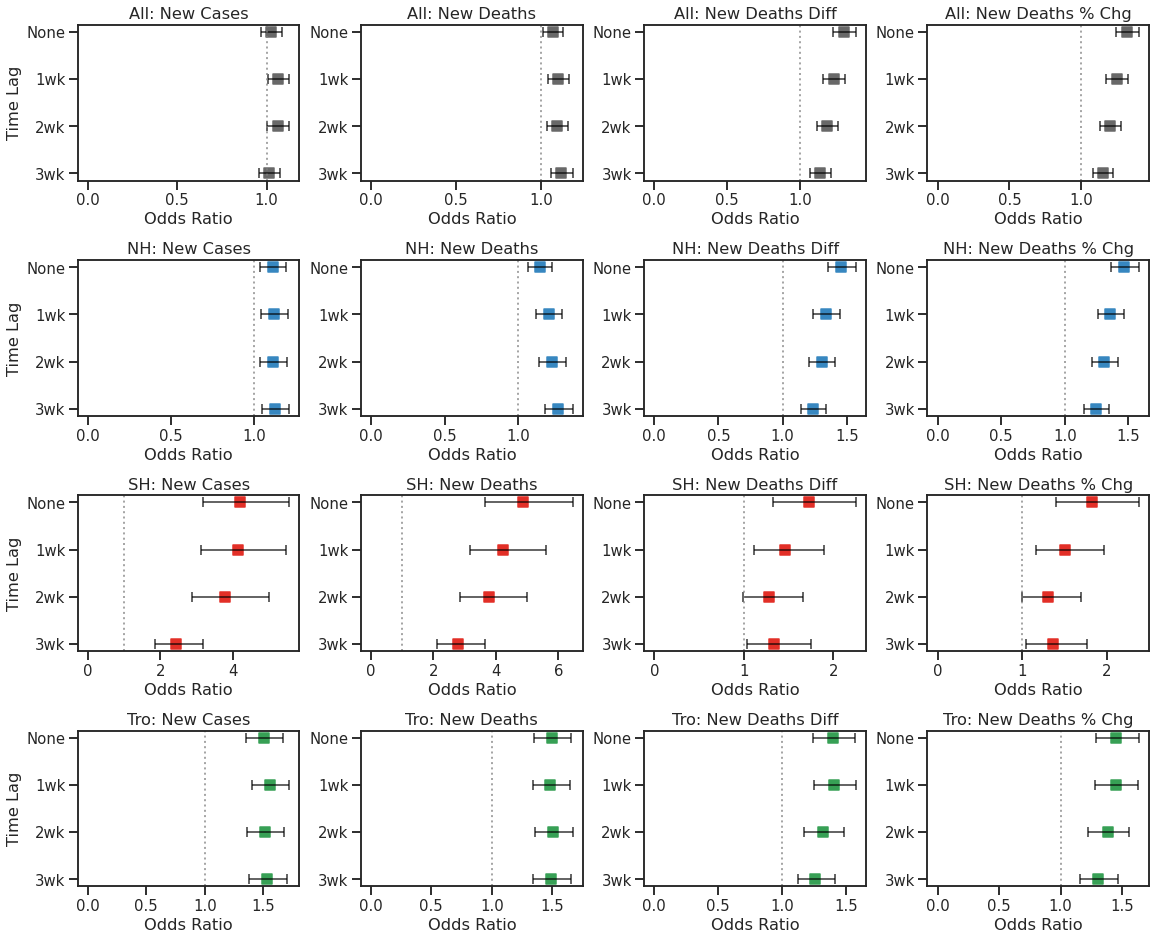

In [ ]:

# Set up the plotting 
quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
dataset_names = ['All','NH','SH','Tro']

#color_array = ['Greys_d','Blues_d','Reds_d','Greens_d']

rows = len(dataset_names); cols = len(quantized_outcomes); fig,ax=plt.subplots(rows,cols,figsize=(16,13))

points = []; lines=[]
# Go through each quantized outbreak metric and make plots 
for col in range(0,cols):
  for lag in range(len(quantized_humidities)):
    for region in range(len(dataset_names)):

      data_for_plotting = df_ORs_byregion.loc[(quantized_outcomes[col],quantized_humidities[lag],dataset_names[region])]
      #lines.append(ax[region,col].plot([data_for_plotting['LCL'],data_for_plotting['UCL']],[lag,lag],color='k',alpha=0.6))
      ax[region,col].errorbar(x=data_for_plotting['odds_ratio'],y=lag,xerr=np.array([data_for_plotting['odds_ratio']-data_for_plotting['LCL'],data_for_plotting['UCL']-data_for_plotting['odds_ratio']]).reshape(-1,1),capsize=5,capthick=2,elinewidth=2,ecolor='k',alpha=0.6,dash_capstyle='butt')
      points.append(ax[region,col].scatter(data_for_plotting['odds_ratio'],lag,marker='s',color='k',alpha=1,s=120))
      ax[region,col].set_yticks(range(0,len(quantized_humidities)))
      ax[region,col].set_yticklabels(['None','1wk','2wk','3wk'])

ax[0,0].set_title('All: New Cases')
ax[1,0].set_title('NH: New Cases')
ax[2,0].set_title('SH: New Cases')
ax[3,0].set_title('Tro: New Cases')

ax[0,1].set_title('All: New Deaths')
ax[1,1].set_title('NH: New Deaths')
ax[2,1].set_title('SH: New Deaths')
ax[3,1].set_title('Tro: New Deaths')

ax[0,2].set_title('All: New Deaths Diff')
ax[1,2].set_title('NH: New Deaths Diff')
ax[2,2].set_title('SH: New Deaths Diff')
ax[3,2].set_title('Tro: New Deaths Diff')

ax[0,3].set_title('All: New Deaths % Chg')
ax[1,3].set_title('NH: New Deaths % Chg')
ax[2,3].set_title('SH: New Deaths % Chg')
ax[3,3].set_title('Tro: New Deaths % Chg')

[ax.set_xlabel('Odds Ratio') for ax in plt.gcf().axes]

[ax[r,0].set_ylabel('Time Lag') for r in np.arange(0,4)]

[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=1)) for i in range(0,64,4)]
[points[i].set_color(sns.color_palette(palette='Blues_d',n_colors=1)) for i in range(1,65,4)]
[points[i].set_color(sns.color_palette(palette='Reds_d',n_colors=1)) for i in range(2,66,4)]
[points[i].set_color(sns.color_palette(palette='Greens_d',n_colors=1)) for i in range(3,67,4)]

[ax.axvline(x=0,color='grey',alpha=0.0,linewidth=0) for ax in plt.gcf().axes]
[ax.axvline(x=1,linestyle=':',color='grey',alpha=0.7,linewidth=2) for ax in plt.gcf().axes]
[ax.invert_yaxis() for ax in plt.gcf().axes]
fig.tight_layout(pad=0.5,h_pad=1.5,w_pad=1)

# Analysis on January dataset

In [ ]:
# 
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/supplementary/7DaySmooth_ALLVars_Dataset_2021_01_27_GE50_Deaths.csv'

# Import Files #df = pd.read_excel('PADDED_Dataset_2020_08_10_GE50_Deaths.xlsx')
df7all = pd.read_csv(filename)

# Drop unnecessary index columns #df.drop(columns='Unnamed: 0',axis=1,inplace=True)
df7all.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Tropic of Cancer is located at 23.5 degrees north of the equator and runs through Mexico, the Bahamas, Egypt, Saudi Arabia, India, and southern China # The Tropic of Capricorn lies at 23.5 degrees south of the equator and runs through Australia, Chile, southern Brazil, and northern South Africa
upper_lat_bound = 23.5; lower_lat_bound = -23.5 
n_hem = df7all[df7all['Lat']>upper_lat_bound]; s_hem = df7all[df7all['Lat']<lower_lat_bound]; trop  = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>lower_lat_bound)]

print('Total Country Count:',df7all['Country'].unique().shape[0]); print('Northern Hemisphere Country Count:',n_hem['Country'].unique().shape[0]); print('Southern Hemisphere Country Count:',s_hem['Country'].unique().shape[0]); print('Tropics Country Count:',trop['Country'].unique().shape[0])

Total Country Count: 155
Northern Hemisphere Country Count: 77
Southern Hemisphere Country Count: 7
Tropics Country Count: 71


In [ ]:
# Assign the region name to each country in the dataset 
df7all.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else 's_hem' if country_name in s_hem['Country'].unique() else 'trop' for country_name in df7all.loc[:,'Country']]

In [ ]:
# Create a dataframe with lagged indoor humidity (from 0 days of lag up to 28 days of lag)
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

df7all_lag_indrh = lagged_var_df(df7all,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)

In [ ]:
first_day = 0; last_day = 180; qlevels = 2; # Parameters for quantizing the dataset 

qtotal = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all['Country'].unique(), retbins=False) # quantize all outbreaks
qnhem = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False) # quantize the N. Hem outbreaks 
qshem = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_hem['Country'].unique(), retbins=False) # quantize the S. Hem outbreaks 
qtrop = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=trop['Country'].unique(), retbins=False) # quantize the Trop outbreaks 

In [ ]:
# Discretize the treatment  
bins = [0,40,60,100] # How to break up the continuous variable (0-40),(40-60),(60-100)
labels = [0,1,2] # How to label the bins 
df7all_lag_indrh['quantized_IndRH'] = pd.cut(df7all_lag_indrh['IndoorRH_pct'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag7'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag7'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag14'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag14'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag21'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag21'],bins=bins,labels=labels) # Use cut to break up the continuous data 

# Binarize the treatment (so <40 and >60 are untreated, 40-60 are treated) 
binary_treatment = df7all_lag_indrh.copy()
binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']] = binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']].replace(2,0)

# Binarize the outbreak metrics 
first_day = 0; last_day = 180; qlevels=2
df7all_lag_indrh_q = quantizer(dataframe=df7all_lag_indrh, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all_lag_indrh['Country'].unique(), retbins=False)
binary_treatment_q = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all_lag_indrh['Country'].unique(), retbins=False)

In [ ]:
# Compute odds ratios by region (All Countries, NH, SH, Trop) 

first_day = 0; last_day = 180; qlevels=2
treat_total = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all['Country'].unique(), retbins=False).dropna()
treat_nhem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False).dropna()
treat_shem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_hem['Country'].unique(), retbins=False).dropna()
treat_trop = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=trop['Country'].unique(), retbins=False).dropna()


quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
dataset_list = [treat_total, treat_nhem, treat_shem, treat_trop]
dataset_names = ['All','NH','SH','Tro']


level3 = []
for outcome in quantized_outcomes: 

  level2 = []
  for humidity in quantized_humidities: 

    
    level1 = [] # Empty list to store each output from the primary calculations

    for dset in dataset_list: 

      computeOR = oddsratio(dataset=dset,outcome=outcome,treatment=humidity) # Compute the odds for NO treatment odds for WITH treatment, odds ratio, LCL, UCL, and pval

      level1.append(computeOR) # Append the output tuple to the list 

    df_level1 = pd.DataFrame(level1, columns =['oddsbad_NO_treatment', 'oddsbad_WITH_treatment', 'odds_ratio','LCL','UCL','pval'],index=dataset_names) # Put all outputs into a labeled dataframe

    level2.append(df_level1) # Put the labeled output dataframe (calculations for each region) into the list of dataframes in level 2 (calculations for each time-lagged humidity value) 
  
  df_level2 = pd.concat(level2,keys=quantized_humidities) # Put all dfs into a multi-index dataframe 

  level3.append(df_level2) # Put the multi-index dataframes (calcs for each region and each time-lag) into the list of dataframes in level 3(calculations for each COVID-19 outbreak metric) 

df_ORs_byregion = pd.concat(level3, keys=quantized_outcomes) # Put all of the multi-index dataframes into a final multi-index dataframe 

print('Done')

Done


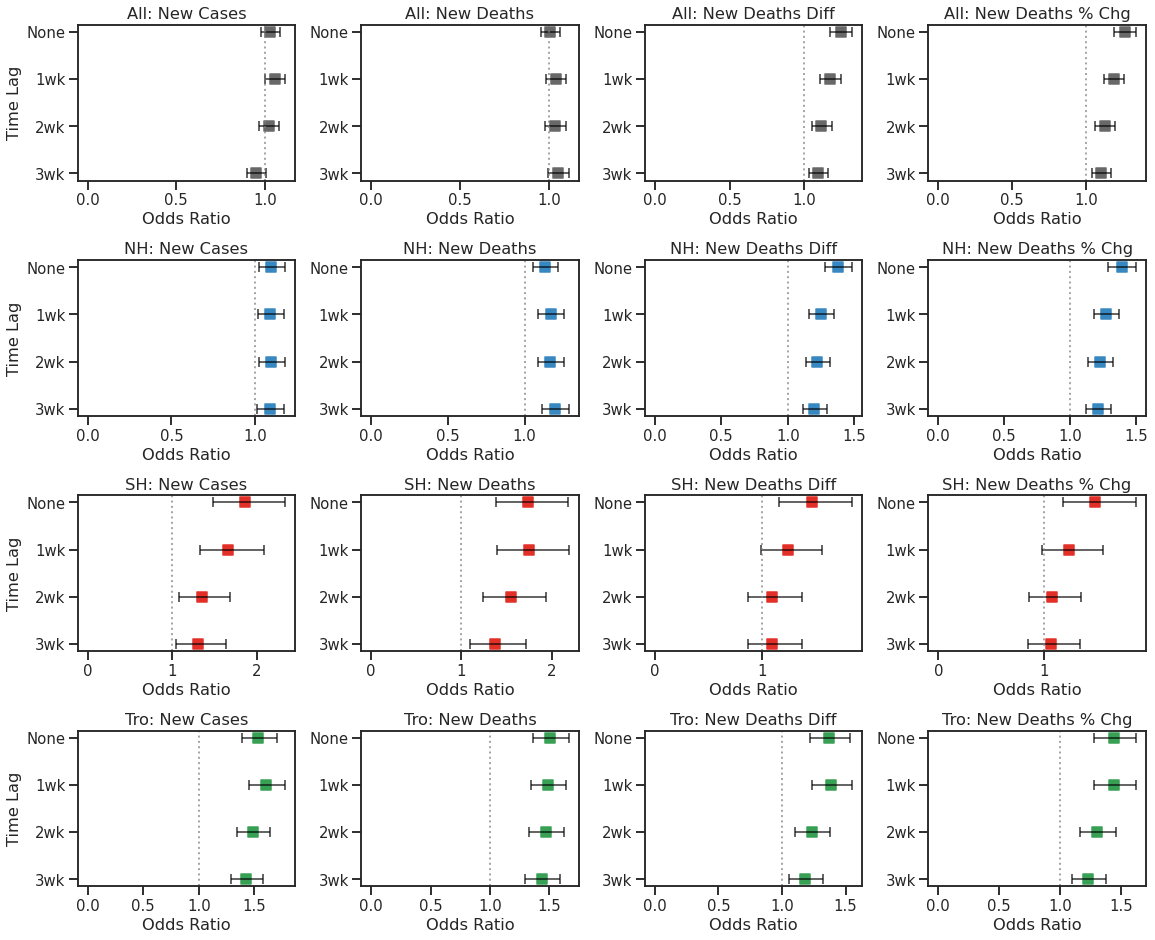

In [ ]:

# Set up the plotting 
quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
dataset_names = ['All','NH','SH','Tro']

#color_array = ['Greys_d','Blues_d','Reds_d','Greens_d']

rows = len(dataset_names); cols = len(quantized_outcomes); fig,ax=plt.subplots(rows,cols,figsize=(16,13))

points = []; lines=[]
# Go through each quantized outbreak metric and make plots 
for col in range(0,cols):
  for lag in range(len(quantized_humidities)):
    for region in range(len(dataset_names)):

      data_for_plotting = df_ORs_byregion.loc[(quantized_outcomes[col],quantized_humidities[lag],dataset_names[region])]
      #lines.append(ax[region,col].plot([data_for_plotting['LCL'],data_for_plotting['UCL']],[lag,lag],color='k',alpha=0.6))
      ax[region,col].errorbar(x=data_for_plotting['odds_ratio'],y=lag,xerr=np.array([data_for_plotting['odds_ratio']-data_for_plotting['LCL'],data_for_plotting['UCL']-data_for_plotting['odds_ratio']]).reshape(-1,1),capsize=5,capthick=2,elinewidth=2,ecolor='k',alpha=0.6,dash_capstyle='butt')
      points.append(ax[region,col].scatter(data_for_plotting['odds_ratio'],lag,marker='s',color='k',alpha=1,s=120))
      ax[region,col].set_yticks(range(0,len(quantized_humidities)))
      ax[region,col].set_yticklabels(['None','1wk','2wk','3wk'])

ax[0,0].set_title('All: New Cases')
ax[1,0].set_title('NH: New Cases')
ax[2,0].set_title('SH: New Cases')
ax[3,0].set_title('Tro: New Cases')

ax[0,1].set_title('All: New Deaths')
ax[1,1].set_title('NH: New Deaths')
ax[2,1].set_title('SH: New Deaths')
ax[3,1].set_title('Tro: New Deaths')

ax[0,2].set_title('All: New Deaths Diff')
ax[1,2].set_title('NH: New Deaths Diff')
ax[2,2].set_title('SH: New Deaths Diff')
ax[3,2].set_title('Tro: New Deaths Diff')

ax[0,3].set_title('All: New Deaths % Chg')
ax[1,3].set_title('NH: New Deaths % Chg')
ax[2,3].set_title('SH: New Deaths % Chg')
ax[3,3].set_title('Tro: New Deaths % Chg')

[ax.set_xlabel('Odds Ratio') for ax in plt.gcf().axes]

[ax[r,0].set_ylabel('Time Lag') for r in np.arange(0,4)]

[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=1)) for i in range(0,64,4)]
[points[i].set_color(sns.color_palette(palette='Blues_d',n_colors=1)) for i in range(1,65,4)]
[points[i].set_color(sns.color_palette(palette='Reds_d',n_colors=1)) for i in range(2,66,4)]
[points[i].set_color(sns.color_palette(palette='Greens_d',n_colors=1)) for i in range(3,67,4)]

[ax.axvline(x=0,color='grey',alpha=0.0,linewidth=0) for ax in plt.gcf().axes]
[ax.axvline(x=1,linestyle=':',color='grey',alpha=0.7,linewidth=2) for ax in plt.gcf().axes]
[ax.invert_yaxis() for ax in plt.gcf().axes]
fig.tight_layout(pad=0.5,h_pad=1.5,w_pad=1)